<a href="https://colab.research.google.com/github/SandersAaronD/Knights_Dialer_Profiler/blob/main/Knight's_Dialer_Performance_Profiling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## The Knight's Dialer

The Knight's Dialer is an old Google interview question. Details can be found [here.](https://alexgolec.dev/google-interview-questions-deconstructed-the-knights-dialer/)

If you want to understand it read the article, this notebook is entirely for determining empirically what the runtimes of the various solutions are. I'll also profile the python @cache decorator and numpy for this problem.

All of this was originally run on Colaboratory, your mileage may vary depending on how your hardware differs from theirs. You will want to set different upper bounds probably, and your cache might behave differently, and so on, and so on, and so on.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import time
import numpy as np

plt.style.use('seaborn-whitegrid')

In [2]:
def profile(fn, args_lists):
  """Profiles input function fn for performance against several sets of arguments and returns a list of runtimes.
  """
  times = []
  for args_list in args_lists:
    tik = time.time()
    y = fn(*args_list)
    tok = time.time()
    times.append(tok-tik)
  
  return times

In [3]:
def make_dialer_profile_graph(fn, upper_bound):
  '''Specific to the knight's dialer, runs the function for all values up to the upper_bound and graphs it.
  '''
  num_hops = list(range(1, upper_bound))
  starting_positions = [1 for _ in range(1, upper_bound)]
  args_lists = zip(starting_positions, num_hops)
  times = profile(fn, args_lists)
  plt.plot(num_hops, times, 'o', color='black')

In [4]:
# Necessary for other knight's dialer functions to run.
NEIGHBORS_MAP = {
    1: (6, 8),
    2: (7, 9),
    3: (4, 8),
    4: (3, 9, 0),
    5: tuple(),  # 5 has no neighbors
    6: (1, 7, 0),
    7: (2, 6),
    8: (1, 3),
    9: (2, 4),
    0: (4, 6),
}
def neighbors(position):
    return NEIGHBORS_MAP[position]

In [5]:
# Naive solution, brute force, basically.
def yield_sequences(starting_position, num_hops, sequence=None):
    if sequence is None:
        sequence = [starting_position]
    
    if num_hops == 0:
        yield sequence
        return

    for neighbor in neighbors(starting_position):
        yield from yield_sequences(
            neighbor, num_hops - 1, sequence + [neighbor])

def count_sequences(starting_position, num_hops):
    num_sequences = 0
    for sequence in yield_sequences(starting_position, num_hops):
        num_sequences += 1
    return num_sequences

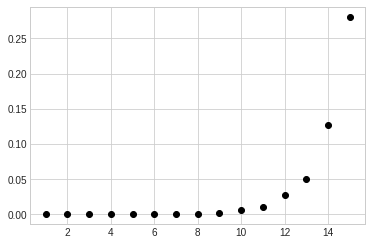

In [6]:
# Choosing an upper bound higher than 16 for this function took an annoyingly long time to run.
make_dialer_profile_graph(count_sequences, 16)

Does anyone dispute that this is exponential? No? Okay, good.

In [7]:
# Basically the same thing, but with recursion, and we don't store the sequences, only count them.
def count_sequences_naive_recursion(start_position, num_hops):                  
    if num_hops == 0:                                           
        return 1                                                
                                                                
    num_sequences = 0                                           
    for position in neighbors(start_position):                  
        num_sequences += count_sequences(position, num_hops - 1)
    return num_sequences   

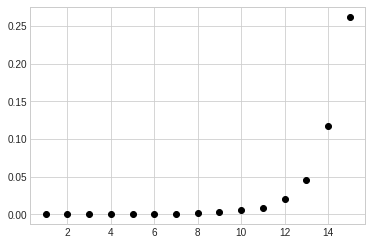

In [8]:
make_dialer_profile_graph(count_sequences_naive_recursion, 16)

Still exponential.

In [9]:
def count_sequences_with_memo(start_position, num_hops):
    cache = {}

    def helper(position, num_hops):
        if (position, num_hops) in cache:
            return cache[ (position, num_hops) ]

        if num_hops == 0:
            return 1

        else:
            num_sequences = 0
            for neighbor in neighbors(position):
                num_sequences += helper(neighbor, num_hops - 1)
            cache[ (position, num_hops) ] = num_sequences
            return num_sequences

    res = helper(start_position, num_hops)
    return res

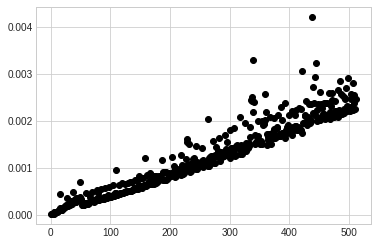

In [10]:
# 1024 throws recursion depth error so we're doing 512.
make_dialer_profile_graph(count_sequences_with_memo, 512)

Nice and flat, O(n) for sure. Now that we're running a lot of values we start to see how 'messy' execution really is; it's flat in aggregate, in general, but individual runtimes for individual function calls are 'noisy'. Still, obviously O(n).

In [11]:
def count_sequences_dynamic_programming(start_position, num_hops):                
    prior_case = [1] * 10                                     
    current_case = [0] * 10                                   
    current_num_hops = 1                                      
                                                              
    while current_num_hops <= num_hops:                       
        current_case = [0] * 10                               
        current_num_hops += 1                                 
                                                              
        for position in range(0, 10):                         
            for neighbor in neighbors(position):              
                current_case[position] += prior_case[neighbor]
        prior_case = current_case                             
                                                              
    return current_case[start_position]   

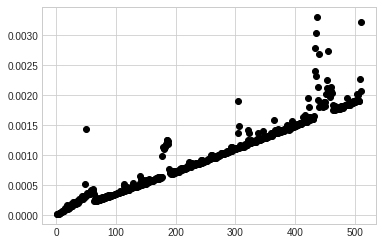

In [12]:
make_dialer_profile_graph(count_sequences_dynamic_programming, 512)

Still flat. Not obviously much faster than recursion with memoization, but 
asymptotically the memory use would matter a lot. Also much 'tighter', make me think the cache resize is where we got the 'noise' in the memoization runtime graph. Allocating more memory is inherently less predictable in runtime than doing a calculation. This is O(1) space complexity, and has no such memory issues.

In [13]:
# In the original post this is called 'neighbors_map' even though it is referred to in the later code as 'neighbors_matrix'.
# This causes an unassigned value error. This is why we can't have nice things.
NEIGHBORS_MATRIX = {
  0: (0, 0, 0, 0, 1, 0, 1, 0, 0, 0),
  1: (0, 0, 0, 0, 0, 0, 1, 0, 1, 0),
  2: (0, 0, 0, 0, 0, 0, 0, 1, 0, 1),
  3: (0, 0, 0, 1, 0, 0, 0, 0, 1, 0),
  4: (1, 0, 0, 1, 0, 0, 0, 0, 0, 1),
  5: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0),
  6: (1, 1, 0, 0, 0, 0, 0, 1, 0, 0),
  7: (0, 0, 1, 0, 0, 0, 1, 0, 0, 0),
  8: (0, 1, 0, 1, 0, 0, 0, 0, 0 ,0),
  9: (0, 0, 1, 0, 1, 0, 0, 0, 0, 0),
}

In [14]:
def matrix_multiply(A, B):
    A_rows, A_cols = len(A), len(A[0])
    B_rows, B_cols = len(B), len(B[0])
    result = list(map(lambda i: [0] * B_cols, range(A_rows)))

    for row in range(A_rows):
        for col in range(B_cols):
            for i in range(B_rows):
                result[row][col] += A[row][i] * B[i][col]

    return result

def count_sequences_with_matrices(start_position, num_hops):
    # Start off with a 10x10 identity matrix
    accum = [[1 if i == j else 0 for i in range(10)] for j in range(10)]

    # bin(num_hops) starts with "0b", slice it off with [2:]
    for bit_num, bit in enumerate(reversed(bin(num_hops)[2:])):
        if bit_num == 0:
            import copy
            power_of_2 = copy.deepcopy(NEIGHBORS_MATRIX)
        else:
            power_of_2 = matrix_multiply(power_of_2, power_of_2)

        if bit == '1':
            accum = matrix_multiply(accum, power_of_2)

    return matrix_multiply(accum, [[1]]*10)[start_position][0]

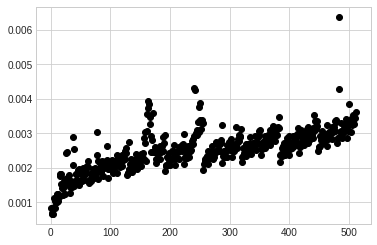

In [15]:
make_dialer_profile_graph(count_sequences_with_matrices, 512)

This is an interesting graph.

Our first real surprise: For the values tested, this is actually slower than either the memoized or dynamic programming solution.

The argument for this algorithm being O(log n) seems pretty sound, but big-O is asymptotic performance. For these (relatively low) values, the overhead on handling matrices (in pure python, no less) is higher than the difference between O(log n) and O(n).

To eyeball the graph, there are a few interesting things. First, the spread is a lot more dramatic than the previous one: this, again, appears noisy. But it doesn't actually appear to be all random noise: it has a period. What kind of period? If I had to hazard a guess, that big drop in the middle is where we hit 256 ... ie, a power of two, requiring fewer intermediate matrix multiplications.

Within the periods there appear to be periods, so probably there is a period for each power of two. This again makes sense: if we are below 3^32 but approaching 2^16, the runtime will drop when we hit 2^16. At 2^16 - 1, we are performing a matrix multiplication for each power of two up to 15, and at 2^16 we are only performing one for that range.

And so on for each power of two. The 'worst' runtime relative to input in a range will always be the one with the most one bits in its binary representation, and a power of two minus one is mostly ones bits.

# Verifying Asymptotic Performance Without Making a Graph

To verify that this is in fact asymptotically faster, rather than running all values up to a specified one (which is what the make_knight_dialer_graph function does) we can simply run the function for a large value several times. We can assume that noise will cancel out over multiple runs, and believing the analysis sound we will expect the O(log n) solution to outperform the O(n) one.

In [16]:
num_hops = [65535 for _ in range(1, 32)]
starting_positions = [1 for _ in range(1, 32)]
args_lists = list(zip(starting_positions, num_hops)) # A fun exercise: Why does this have to be a list instead of a zip?

times_for_matrices = profile(count_sequences_with_matrices, args_lists)

print("Runtime for the matrix solution:")
print(sum(times_for_matrices))

times_for_dp = profile(count_sequences_dynamic_programming, args_lists)

print("Runtime for the dp solution:")
print(sum(times_for_dp))

Runtime for the matrix solution:
25.546484231948853
Runtime for the dp solution:
61.77008271217346


Since those are full seconds, the O(n) solution chugged along for something of an eon of extra time in computer time and we can declare the O(log n) solution the winner.

While writing and debugging this I noticed something else. See if you can spot it:

In [17]:
print(count_sequences(1, 8))
print(count_sequences_naive_recursion(1, 8))
print(count_sequences_with_memo(1, 8))
print(count_sequences_dynamic_programming(1, 8))
print(count_sequences_with_matrices(1, 8))

712
712
712
712
613


One of these things just isn't the same. Could the problem be our matrix multiply?

In [18]:
import numpy as np

A = [[8, 6, 7],
    [5, 3, 0],
    [9, 9, 9]]

B = [[3, 1, 4],
    [1, 5, 9],
    [2, 6, 5]]

print(np.matrix(A) @ np.matrix(B))

print(matrix_multiply(A, B))

[[ 44  80 121]
 [ 18  20  47]
 [ 54 108 162]]
[[44, 80, 121], [18, 20, 47], [54, 108, 162]]


Either Numpy is wrong or this matrix multiply is good, at least outside of weird edge cases. (Numpy is a surprise tool that will help us later.)

Is the NEIGHBORS_MATRIX correct? I confess that I cannot easily read off its correctness or incorrectness, and it will be easier to write a script that outputs which keys allow you to reach which other keys and then compare that against my phone keypad.

In [19]:
for origin in NEIGHBORS_MATRIX.keys():
  for destination, reachable in enumerate(NEIGHBORS_MATRIX[origin]):
    if reachable:
      print((origin, destination))

(0, 4)
(0, 6)
(1, 6)
(1, 8)
(2, 7)
(2, 9)
(3, 3)
(3, 8)
(4, 0)
(4, 3)
(4, 9)
(6, 0)
(6, 1)
(6, 7)
(7, 2)
(7, 6)
(8, 1)
(8, 3)
(9, 2)
(9, 4)


(3, 3) is our mistake. It should be (3, 4).

In [20]:
NEIGHBORS_MATRIX = {
  0: (0, 0, 0, 0, 1, 0, 1, 0, 0, 0),
  1: (0, 0, 0, 0, 0, 0, 1, 0, 1, 0),
  2: (0, 0, 0, 0, 0, 0, 0, 1, 0, 1),
  3: (0, 0, 0, 0, 1, 0, 0, 0, 1, 0),
  4: (1, 0, 0, 1, 0, 0, 0, 0, 0, 1),
  5: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0),
  6: (1, 1, 0, 0, 0, 0, 0, 1, 0, 0),
  7: (0, 0, 1, 0, 0, 0, 1, 0, 0, 0),
  8: (0, 1, 0, 1, 0, 0, 0, 0, 0 ,0),
  9: (0, 0, 1, 0, 1, 0, 0, 0, 0, 0),
}

print(count_sequences_with_matrices(1, 8))

712


Much better. It's possible that this glitch was causing more zero values and therefore a faster runtime, and gave this implementation an advantage, so we'll need to run our race again.

In [21]:
num_hops = [65535 for _ in range(1, 32)]
starting_positions = [1 for _ in range(1, 32)]
args_lists = list(zip(starting_positions, num_hops))

times_for_matrices = profile(count_sequences_with_matrices, args_lists)

print("Runtime for the matrix solution:")
print(sum(times_for_matrices))

times_for_dp = profile(count_sequences_dynamic_programming, args_lists)

print("Runtime for the dp solution:")
print(sum(times_for_dp))

Runtime for the matrix solution:
5.677034616470337
Runtime for the dp solution:
61.94935727119446


Not at all! It turns out it's much faster with the error gone. Why? I would assume the (3, 3) value was causing the value in (3, 3) to grow significantly faster than it would otherwise, which in turn caused the arithmetic to need larger numbers, consuming more resources.

Now let's try to compare the python @cache decorator with hand-implemented caching, and numpy with our handrolled matrix multiply.

In [22]:
import functools

@functools.lru_cache()
def count_sequences_with_imported_cache(position, num_hops):
    if num_hops == 0:
        return 1
    else:
        num_sequences = 0
        for neighbor in neighbors(position):
            num_sequences += count_sequences_with_imported_cache(neighbor, num_hops - 1)
        return num_sequences
    return res

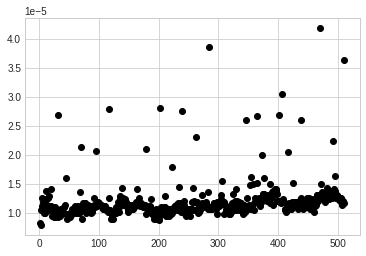

In [23]:
make_dialer_profile_graph(count_sequences_with_imported_cache, 512)

The imported cache is at least three orders of magnitude faster than using a python dictionary was. Why? Because some of the underlying implementation is in C.

I don't think I will be implementing caching by hand very much any more.

In [24]:
NEIGHBORS_MATRIX_NP = np.matrix([x for x in NEIGHBORS_MATRIX.values()])

def count_sequences_with_np_matrices(start_position, num_hops):
    # Apologies for the code golf.
    return np.sum(np.linalg.matrix_power(NEIGHBORS_MATRIX_NP, num_hops)[start_position])

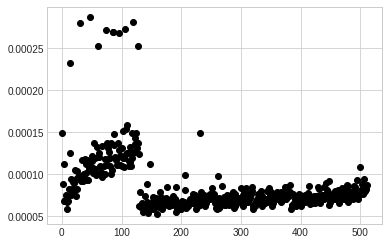

In [25]:
make_dialer_profile_graph(count_sequences_with_np_matrices, 512)

Same story: Much faster, and it's because the underlying implementation is at least partially in C. It was also a lot easier to write, I imagine.